**Цель домашнего задания**: побороть галлюцинации Mistral в чат-режиме. Научиться обрабатывать сложные pdf-документы.

Данная домашняя работа состоит из 2 частей: в первой вы закрепите знания по LoRA и дообучению LLM, а во второй научитесь обрабатывать pdf-документы, что пригодится вам при работе над проектом.

### План работ:

- Протестировать предобученную модель в качестве ассистента интернет-магазина.
- Дообучить модель методом LoRA на данных общения чат-бота с клиентами по различным товарам.
- Протестировать дообученную модель.
- Изучить возможности парсинга pdf-документов.
- Применить полученные данные для парсинга документов из проекта.

# Часть 1. Fine-tune Mistral 7B.

In [2]:
!pip install peft transformers bitsandbytes accelerate trl datasets -U -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

Протестируем сначала, как справится с этой задачей предобученная на русский язык Mistral 7b (оригинальная модель училась только на английский язык). Пусть модель будет играть роль ассистента для интеренат-магазина смартфонов.

In [4]:
MODEL_NAME = "IlyaGusev/saiga_mistral_7b"
MESSAGE_TEMPLATE = "<s>{role}\n{content}</s>"
RESPONSE_TEMPLATE = "<s>bot\n"
SYSTEM_PROMPT = """Ты – чат-бот технической поддержки Xiaomi Store, который помогает клиенту выбрать наиболее подходящий для него смартфон. Опираясь на описание смартфонов, помоги клиенту выбрать наиболее подходящий для него смартфон. Если ответа на вопрос клиента нет в приведенном описании, ответь "У меня не достаточно информации для ответа на ваш вопрос. Обратитесь пожалуйста к менеджеру в telegram".
Описание смартфонов из интернет-магазина сотовой связи Xiaomi Store:
1. Смартфон Xiaomi Redmi Note 10 Pro: Этот смартфон оснащен дисплеем Super AMOLED с разрешением 1080 x 2400 пикселей, что обеспечивает четкую и яркую картинку. Он также имеет камеру на 64 Мп с возможностью записи видео в 4K. Процессор Snapdragon 732G обеспечивает отличную производительность, а аккумулятор на 5020 мАч обеспечивает долгое время работы.
2. Смартфон Xiaomi Mi 11 Lite: Этот смартфон имеет ультратонкий и легкий дизайн, который удобно держать в руке. Он оснащен 6.55-дюймовым AMOLED-дисплеем с разрешением 1080 x 2400 пикселей. Камера на 64 Мп способна делать качественные фотографии, а быстрый процессор Qualcomm Snapdragon 732G позволяет работать с приложениями плавно.
3. Смартфон Xiaomi Redmi 9T: Этот смартфон оснащен 6.53-дюймовым IPS-дисплеем с разрешением 1080 x 2340 пикселей, который обеспечивает реалистичную цветопередачу. Камера на 48 Мп делает четкие фото, а процессор Snapdragon 662 обеспечивает быструю работу. Аккумулятор на 6000 мАч позволяет использовать устройство долгое время без подзарядки.
4. Смартфон Xiaomi Mi 10T Pro: Этот смартфон оснащен 6.67-дюймовым IPS-дисплеем с разрешением 1080 x 2400 пикселей. Он имеет камеру на 108 Мп, что позволяет делать потрясающие фотографии. Процессор Qualcomm Snapdragon 865 обеспечивает высокую производительность, а аккумулятор на 5000 мАч гарантирует долгое время работы.
5. Смартфон Xiaomi Redmi Note 9 Pro: Этот смартфон оснащен 6.67-дюймовым IPS-дисплеем с разрешением 1080 x 2400 пикселей. Камера на 64 Мп с поддержкой искусственного интеллекта позволяет делать яркие и четкие фотографии. Процессор Snapdragon 720G обеспечивает отличную производительность, а аккумулятор на 5020 мАч обеспечивает долгое время работы.
6. Смартфон Xiaomi Mi 10T Lite: Этот смартфон оснащен 6.67-дюймовым IPS-дисплеем с разрешением 1080 x 2400 пикселей. Он имеет камеру на 64 Мп, что позволяет делать яркие и детальные фотографии. Процессор Qualcomm Snapdragon 750G ускоряет работу с приложениями, а аккумулятор на 4820 мАч обеспечивает долгую автономность.
7. Смартфон Xiaomi Redmi Note 8 Pro: Этот смартфон оснащен 6.53-дюймовым IPS-дисплеем с разрешением 1080 x 2340 пикселей. Камера на 64 Мп делает четкие и яркие фото, а процессор MediaTek Helio G90T обеспечивает плавную работу. Аккумулятор на 4500 мАч достаточно емкий для долгого использования.
8. Смартфон Xiaomi Mi 10 Pro: Этот смартфон оснащен 6.67-дюймовым AMOLED-дисплеем с разрешением 1080 x 2340 пикселей. Камера на 108 Мп и оптическая стабилизация изображения позволяют делать высококачественные фотографии. Процессор Snapdragon 865 ускоряет работу с приложениями, а аккумулятор на 4500 мАч достаточно емкий.
9. Смартфон Xiaomi Redmi 9C: Этот смартфон оснащен 6.53-дюймовым IPS-дисплеем с разрешением 720 x 1600 пикселей. Он имеет камеру на 13 Мп, которая делает четкие фото в хороших условиях освещения. Процессор MediaTek Helio G35 обеспечивает достаточную производительность для базовых задач, а аккумулятор на 5000 мАч обеспечивает долгое время работы.
10. Смартфон Xiaomi Mi 11 Ultra: Этот смартфон оснащен 6.81-дюймовым AMOLED-дисплеем с разрешением 1440 x 3200 пикселей. Он имеет камеру на 50 Мп, а также вспомогательные камеры для различных эффектов съемки. Процессор Snapdragon 888 обеспечивает высокую производительность, а аккумулятор на 5000 мАч гарантирует долгое время работы."""

In [5]:
class Conversation:
    def __init__(
        self,
        message_template=MESSAGE_TEMPLATE,
        system_prompt=SYSTEM_PROMPT,
        response_template=RESPONSE_TEMPLATE
    ):
        # Инициализация класса Conversation с шаблонами сообщений и системным запросом.
        # message_template - шаблон для каждого сообщения (например, форматирование текста).
        # system_prompt - начальный запрос, задающий контекст разговора.
        # response_template - шаблон для ответа, который будет добавлен в конце текста.

        self.message_template = message_template  # Сохранение шаблона сообщений.
        self.response_template = response_template  # Сохранение шаблона ответа.
        # Инициализация списка сообщений с первым сообщением от системы, определяющим контекст беседы.
        self.messages = [{
            "role": "system",
            "content": system_prompt
        }]

    def add_user_message(self, message):
        # Метод для добавления сообщения пользователя в список сообщений.
        self.messages.append({
            "role": "user",
            "content": message
        })

    def add_bot_message(self, message):
        # Метод для добавления сообщения бота в список сообщений.
        self.messages.append({
            "role": "bot",
            "content": message
        })

    def get_prompt(self, tokenizer):
        # Метод для формирования финального текста запроса, который будет отправлен для генерации ответа.
        final_text = ""  # Инициализация переменной для хранения окончательного текста.
        for message in self.messages:
            # Форматирование каждого сообщения в соответствии с message_template.
            message_text = self.message_template.format(**message)
            final_text += message_text  # Добавление отформатированного текста к итоговому.

        final_text += RESPONSE_TEMPLATE  # Добавление шаблона ответа в конце текста.
        return final_text.strip()  # Возвращение итогового текста без лишних пробелов в начале и в конце.


In [6]:
def generate(model, tokenizer, prompt, generation_config):
    # Функция для генерации текста на основе заданного промпта с использованием модели и токенизатора.

    # Токенизация промпта: превращаем текстовый промпт в числовые представления (токены),
    # которые понимает модель. Параметр return_tensors="pt" означает, что данные
    # будут возвращены в формате PyTorch тензоров. add_special_tokens=False указывает,
    # что специальные токены (например, [CLS], [SEP]) не будут добавлены.
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)

    # Переносим данные на устройство, на котором работает модель (например, GPU или CPU).
    data = {k: v.to(model.device) for k, v in data.items()}

    # Генерация выходных идентификаторов (токенов) с использованием модели.
    # Параметр generation_config задает конфигурацию генерации, например,
    # максимальную длину ответа, температуру и т.д.
    output_ids = model.generate(
        **data,
        generation_config=generation_config
    )[0]

    # Обрезаем выходные идентификаторы, чтобы исключить исходные токены промпта.
    # Таким образом, оставляем только сгенерированный моделью ответ.
    output_ids = output_ids[len(data["input_ids"][0]):]

    # Декодируем токены обратно в текст, исключая специальные токены, такие как [PAD] или [SEP].
    output = tokenizer.decode(output_ids, skip_special_tokens=True)

    # Возвращаем итоговый сгенерированный текст, убирая лишние пробелы в начале и в конце.
    return output.strip()

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config

tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

GenerationConfig {
  "bos_token_id": 1,
  "do_sample": true,
  "eos_token_id": 2,
  "max_new_tokens": 1536,
  "no_repeat_ngram_size": 15,
  "pad_token_id": 0,
  "repetition_penalty": 1.1,
  "temperature": 0.2,
  "top_k": 40,
  "top_p": 0.9
}

In [8]:
# Загружаем конфигурацию модели PeftConfig из предобученной модели, используя ее имя.
config = PeftConfig.from_pretrained(MODEL_NAME)

# Загружаем предобученную модель для задачи автозавершения текста (Causal Language Modeling).
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,  # Используем базовую модель из конфигурации.
    load_in_8bit=False,  # Загружаем модель с точностью float16, а не 8-битную версию.
    torch_dtype=torch.float16,  # Определяем тип данных тензоров как 16-битные числа с плавающей запятой (fp16).
    device_map="auto",  # Автоматически распределяем модель по доступным устройствам (например, на GPU, если он доступен).
)

model = PeftModel.from_pretrained(model, MODEL_NAME, torch_dtype=torch.float16)

# Переводим модель в режим оценки, чтобы отключить функции, используемые только при обучении,
# такие как dropout, и настроить модель на генерацию предсказаний.
model.eval()


adapter_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/54.6M [00:00<?, ?B/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32002, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [9]:
conversation = Conversation()

In [10]:
#Привет! Подскажите какие у вас есть ноутбуки
while True:
    user_uttr = input("Клиент: ")
    if user_uttr == '':
        break
    conversation.add_user_message(user_uttr)
    prompt = conversation.get_prompt(tokenizer)
    output = generate(model, tokenizer, prompt, generation_config)
    output = output.split("bot")[0].strip()
    print(f"Чат-бот: {output}")

Клиент: Привет! Подскажите какие у вас есть ноутбуки
Чат-бот: В нашем магазине представлены следующие модели ноутбуков:

1. Xiaomi Notebook Air 13.3: Этот ноутбук оснащен 13.3-дюймовым Full HD дисплеем с разрешением 1920 x 1080 пикселей. Он имеет процессор Intel Core i5-8250U, графический процессор NVIDIA GeForce MX150 и оперативную память 8 ГБ. Ноутбук также оснащен SSD на 256 ГБ, что обеспечивает быструю работу.

2. Xiaomi Notebook Pro 15.6: Этот ноутбук оснащен 15.6-дюймовым Full HD дисплеем с высоким коэффициентом проницаемости (anti-glare) и разрешением 1920 x 108. Он имеет процессор Intel Core i5-8265U, графический процессор NVIDIA GeForce Mx250 и оперативную память 8 ГБ. Набор жесткого диска составляет 512 ГБ.

3. Xiaomi Notebook Pro 15.6: Эта модель оснащена 15.6-дюймовым Full HD диплексом с разрешением 1920 x 10. Он имеет процессор Intel Core i7-8550U, графический процессор NVIDIA GeFore MX250 и оперативную память 16 ГБ. Набор жесткого диска составляет 500 ГБ.

4. Xiaomi Noteb

Начинаем общение. Попробуйте попросить рассказать про планшеты, которые имеют качество видео 4К. Видим, что бот начинает придумывать несуществующую информацию, то есть начинает галлюцинировать.

Скачиваем данные для дообучения.

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_xKwkNFisKzDQ1CPPDqvKWdPRzZvO4MT' -O company_cases.json

--2025-06-09 16:34:47--  https://docs.google.com/uc?export=download&id=1_xKwkNFisKzDQ1CPPDqvKWdPRzZvO4MT
Resolving docs.google.com (docs.google.com)... 173.194.64.101, 173.194.64.102, 173.194.64.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.64.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1_xKwkNFisKzDQ1CPPDqvKWdPRzZvO4MT&export=download [following]
--2025-06-09 16:34:47--  https://drive.usercontent.google.com/download?id=1_xKwkNFisKzDQ1CPPDqvKWdPRzZvO4MT&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.195.132, 2607:f8b0:4001:c1d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70497894 (67M) [application/octet-stream]
Saving to: ‘company_cases.json’

company_cases.json  100%[===================>]  67.23M   151MB/

In [1]:
import json
import torch
from datasets import Dataset
from peft import LoraConfig
from sklearn.model_selection import train_test_split
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM

In [2]:
with open("company_cases.json", 'r') as inp:
    raw_dataset = json.load(inp)

train_raw_dataset, test_raw_dataset = train_test_split(raw_dataset)
train_test_raw_dataset = {"train": train_raw_dataset, "test": test_raw_dataset}

Преобразуем датасет в формат, который используется в классе Dataset.

In [3]:
raw_dataset_dict = {}
for data_type in ["train", "test"]:
    raw_dataset_dict[data_type] = {
        "instruction": [element['instruction'] for element in train_test_raw_dataset[data_type]],
        "personality": [element['personality'] for element in train_test_raw_dataset[data_type]],
        "context": [element['context'] for element in train_test_raw_dataset[data_type]],
        "dialog_start_line": [element['instruction'] for element in train_test_raw_dataset[data_type]],
        "dialog": [element['dialog'] for element in train_test_raw_dataset[data_type]]
    }

train_dataset = Dataset.from_dict(raw_dataset_dict["train"])
test_dataset = Dataset.from_dict(raw_dataset_dict["test"])

Функция для форматирования промпта.

In [4]:
def formatting_prompts_func(examples):
    prompts = []
    for i in range(len(examples['instruction'])):
        prompt = f"<s>system\n{examples['instruction'][i]}"
        if examples['personality'][i]:
            prompt += f"\n{examples['personality'][i]}"
        prompt += f"\n{examples['context'][i]}"
        if examples['dialog_start_line']:
            prompt += f"\n{examples['dialog_start_line'][i]}"
        prompt += "</s>"
        for element in examples['dialog'][i]:
            prompt += f"<s>{element['role']}\n{element['content']}</s>"
        prompts.append(prompt)
    return prompts

Для дообучения возьмем не готовый уже русскоязычный Mistral, а предобученный Mistral на датасете Open-Orca.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("Open-Orca/Mistral-7B-OpenOrca")
tokenizer.pad_token_id = 0

Сделаем, чтобы градиент при обучении протекал только через токены последней реплики чат-бота, labels у остальных токенов сделаем равными -100.

In [6]:
response_template = "bot\n"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [7]:
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True)

model = AutoModelForCausalLM.from_pretrained(
    "Open-Orca/Mistral-7B-OpenOrca",
    torch_dtype=torch.bfloat16,
    device_map='auto',
    quantization_config=quantization_config
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Задаем LoraConfig.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
peft_config = LoraConfig(r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="lora_only",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj'])

Задаем параметры для дообучения.

In [17]:
training_arguments = TrainingArguments(output_dir = '/content',
                                       per_device_train_batch_size = 2,
                                       per_device_eval_batch_size = 2,
                                       num_train_epochs = 1,
                                       learning_rate =5e-5,
                                       eval_strategy = "no",
                                       eval_steps = 50,
                                       bf16 = True,
                                       fp16 = False,
                                       gradient_accumulation_steps=4,
                                       optim="adamw_torch",
                                       logging_steps=100,
                                       report_to=[],
)

Начинаем дообучение.

In [18]:
trainer = SFTTrainer(
    model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
    peft_config=peft_config,
    args=training_arguments,
    # max_length=2048,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Applying formatting function to train dataset:   0%|          | 0/8354 [00:00<?, ? examples/s]

Applying formatting function to train dataset:   0%|          | 0/8354 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/8354 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/8354 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8354 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/8354 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/2785 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/2785 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/2785 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/2785 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/2785 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2785 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/trl/trainer/utils.py:150: UserWarning: Could not find response key `bot
` in the following instance: <s><s> system
Ниже представлено описание 5 номеров сети отелей Choice Hotels International. Ты – чат-бот choice hotels international, который помогает клиенту выбрать наиболее подходящий для него номер. Опираясь на описание номеров, помоги клиенту выбрать наиболее подходящий для него номер.
Личность чат-бота: юмористический и беззаботный – чат-бот настроен добавлять нотку юмора в свои взаимодействия, делая разговоры приятными.
1. Номер Suite с двуспальной кроватью:
Этот просторный номер предлагает комфортное проживание с двуспальной кроватью и отдельной гостиной зоной. В номере имеется комфортн

Streaming output truncated to the last 5000 lines.
- Размер минимального взноса: 100 000 рублей
9. Инвестиционный продукт "Финансовые инструменты развития"
- Комиссия: 0,1% от суммы сделки
- Доходность: до 9% в год
- Размер минимального взноса: 10 000 рублей
10. Инвестиционный продукт "Недвижимость"
- Комиссия: 0,5% от суммы сделки
- Доходность: до 20% в год
- Размер минимального взноса: 1 000 000 рублей
Ниже представлено описание 10 инвестиционных предложений банка Тинькофф Банк с указанием комиссии, доходности и размера минимального взноса. Ты – чат-бот технической поддержки тинькофф банк, который помогает клиенту выбрать. This instance will be ignored in loss calculation. Note, if this happens often, consider increasing the `max_length`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/utils.py:150: UserWarning: Could not find response key `bot
` in the following instance: <s><s> system
Ниже представлено описание 10 моделей фотоаппаратов из интернет-магазина элек

Выходные данные были обрезаны до нескольких последних строк (5000).
5. Жилой комплекс "Акрополь"
Расположение: Краснодар, Центральный район
Описание: Жилой комплекс "Акрополь" находится в историческом центре города, недалеко от главных достопримечательностей. Здесь представлены элитные квартиры с современной планировкой и отличным видом на город. Территория комплекса охраняется, есть подземная парковка и объекты коммерческой инфраструктуры.
6. Жилой комплекс "Жемчужина"
Расположение: Краснодар, Прикубанский район
Описание: Жилой комплекс "Жемчужина" находится в престижном районе города, рядом с парком и озером. Здесь представлены квартиры различных планировок с качественной отделкой. На территории комплекса есть детская площадка, зона отдыха, а также. This instance will be ignored in loss calculation. Note, if this happens often, consider increasing the `max_length`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/trl/trainer/utils.py:150: UserWarning: Could not find response 

TrainOutput(global_step=1045, training_loss=0.6014911907141288, metrics={'train_runtime': 3420.6181, 'train_samples_per_second': 2.442, 'train_steps_per_second': 0.306, 'total_flos': 3.6431585439994675e+17, 'train_loss': 0.6014911907141288})

Тестируем получившуюся модель.

In [19]:
%cp -r /content/checkpoint-1045 /content/drive/MyDrive/hw5/checkpoint-1045

In [20]:
import torch
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

Загружаем чекпонит адаптера.

In [26]:
BASE_MODEL = "Open-Orca/Mistral-7B-OpenOrca"
ADAPTER_MODEL = "/content/checkpoint-1045"
MESSAGE_TEMPLATE = "<s>{role}\n{content}</s>"
RESPONSE_TEMPLATE = "<s>bot\n"
SYSTEM_PROMPT = """Ты – чат-бот технической поддержки Xiaomi Store, который помогает клиенту выбрать наиболее подходящий для него смартфон. Опираясь на описание смартфонов, помоги клиенту выбрать наиболее подходящий для него смартфон. Если ответа на вопрос клиента нет в приведенном описании, ответь "У меня не достаточно информации для ответа на ваш вопрос. Обратитесь пожалуйста к менеджеру в telegram".{personality}
Описание смартфонов из интернет-магазина сотовой связи Xiaomi Store:
1. Смартфон Xiaomi Redmi Note 10 Pro: Этот смартфон оснащен дисплеем Super AMOLED с разрешением 1080 x 2400 пикселей, что обеспечивает четкую и яркую картинку. Он также имеет камеру на 64 Мп с возможностью записи видео в 4K. Процессор Snapdragon 732G обеспечивает отличную производительность, а аккумулятор на 5020 мАч обеспечивает долгое время работы.
2. Смартфон Xiaomi Mi 11 Lite: Этот смартфон имеет ультратонкий и легкий дизайн, который удобно держать в руке. Он оснащен 6.55-дюймовым AMOLED-дисплеем с разрешением 1080 x 2400 пикселей. Камера на 64 Мп способна делать качественные фотографии, а быстрый процессор Qualcomm Snapdragon 732G позволяет работать с приложениями плавно.
3. Смартфон Xiaomi Redmi 9T: Этот смартфон оснащен 6.53-дюймовым IPS-дисплеем с разрешением 1080 x 2340 пикселей, который обеспечивает реалистичную цветопередачу. Камера на 48 Мп делает четкие фото, а процессор Snapdragon 662 обеспечивает быструю работу. Аккумулятор на 6000 мАч позволяет использовать устройство долгое время без подзарядки.
4. Смартфон Xiaomi Mi 10T Pro: Этот смартфон оснащен 6.67-дюймовым IPS-дисплеем с разрешением 1080 x 2400 пикселей. Он имеет камеру на 108 Мп, что позволяет делать потрясающие фотографии. Процессор Qualcomm Snapdragon 865 обеспечивает высокую производительность, а аккумулятор на 5000 мАч гарантирует долгое время работы.
5. Смартфон Xiaomi Redmi Note 9 Pro: Этот смартфон оснащен 6.67-дюймовым IPS-дисплеем с разрешением 1080 x 2400 пикселей. Камера на 64 Мп с поддержкой искусственного интеллекта позволяет делать яркие и четкие фотографии. Процессор Snapdragon 720G обеспечивает отличную производительность, а аккумулятор на 5020 мАч обеспечивает долгое время работы.
6. Смартфон Xiaomi Mi 10T Lite: Этот смартфон оснащен 6.67-дюймовым IPS-дисплеем с разрешением 1080 x 2400 пикселей. Он имеет камеру на 64 Мп, что позволяет делать яркие и детальные фотографии. Процессор Qualcomm Snapdragon 750G ускоряет работу с приложениями, а аккумулятор на 4820 мАч обеспечивает долгую автономность.
7. Смартфон Xiaomi Redmi Note 8 Pro: Этот смартфон оснащен 6.53-дюймовым IPS-дисплеем с разрешением 1080 x 2340 пикселей. Камера на 64 Мп делает четкие и яркие фото, а процессор MediaTek Helio G90T обеспечивает плавную работу. Аккумулятор на 4500 мАч достаточно емкий для долгого использования.
8. Смартфон Xiaomi Mi 10 Pro: Этот смартфон оснащен 6.67-дюймовым AMOLED-дисплеем с разрешением 1080 x 2340 пикселей. Камера на 108 Мп и оптическая стабилизация изображения позволяют делать высококачественные фотографии. Процессор Snapdragon 865 ускоряет работу с приложениями, а аккумулятор на 4500 мАч достаточно емкий.
9. Смартфон Xiaomi Redmi 9C: Этот смартфон оснащен 6.53-дюймовым IPS-дисплеем с разрешением 720 x 1600 пикселей. Он имеет камеру на 13 Мп, которая делает четкие фото в хороших условиях освещения. Процессор MediaTek Helio G35 обеспечивает достаточную производительность для базовых задач, а аккумулятор на 5000 мАч обеспечивает долгое время работы.
10. Смартфон Xiaomi Mi 11 Ultra: Этот смартфон оснащен 6.81-дюймовым AMOLED-дисплеем с разрешением 1440 x 3200 пикселей. Он имеет камеру на 50 Мп, а также вспомогательные камеры для различных эффектов съемки. Процессор Snapdragon 888 обеспечивает высокую производительность, а аккумулятор на 5000 мАч гарантирует долгое время работы."""

In [27]:
class Conversation:
    def __init__(
        self,
        message_template=MESSAGE_TEMPLATE,
        system_prompt=SYSTEM_PROMPT,
        response_template=RESPONSE_TEMPLATE,
        personality=None
    ):
        self.message_template = message_template
        self.response_template = response_template
        if personality:
            system_prompt = system_prompt.format(personality=personality)
        else:
            system_prompt = system_prompt.format(personality="")
        self.messages = [{
            "role": "system",
            "content": system_prompt
        }]

    def add_user_message(self, message):
        self.messages.append({
            "role": "user",
            "content": message
        })

    def add_bot_message(self, message):
        self.messages.append({
            "role": "bot",
            "content": message
        })

    def get_prompt(self, tokenizer):
        final_text = ""
        for message in self.messages:
            message_text = self.message_template.format(**message)
            final_text += message_text
        final_text += RESPONSE_TEMPLATE
        return final_text.strip()

In [28]:
def generate(model, tokenizer, prompt, generation_config):
    data = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    data = {k: v.to(model.device) for k, v in data.items()}
    output_ids = model.generate(
        **data,
        generation_config=generation_config
    )[0]
    output_ids = output_ids[len(data["input_ids"][0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True)
    return output.strip()

In [36]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=False)
tokenizer.pad_token_id = 0
generation_config = GenerationConfig(
    pad_token_id=0,
    bos_token_id=1,
    eos_token_id=2,
    max_new_tokens=256,
)

In [30]:
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    load_in_8bit=False,
    torch_dtype=torch.float16,
    device_map="auto",
)
model = PeftModel.from_pretrained(model, ADAPTER_MODEL, torch_dtype=torch.float16)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32002, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.L

In [31]:
conversation = Conversation()

Снова запускаем диалог и спрашиваем про планшеты. Удалось побороть галлюцинации?

In [39]:
while True:
    user_uttr = input("Клиент: ")
    if user_uttr == '':
        break
    conversation.add_user_message(user_uttr)
    prompt = conversation.get_prompt(tokenizer)
    output = generate(model, tokenizer, prompt, generation_config)
    output = output.split("bot")[0].replace("<s>", "").replace("</s>", "").strip()
    print(f"Чат-бот: {output}")

Клиент: Расскажите какие у вас есть ноутбуки
Чат-бот: К сожалению, в нашем магазине мы не продаем ноутбуки. Мы специализируемся на продаже смартфонов.
Клиент: А какие есть планшеты 4к?
Чат-бот: У меня не достаточно информации для ответа на ваш вопрос. Обратитесь пожалуйста к менеджеру в telegram.
Клиент: Ладно, а у какого телефона больше всего аккумулятор?
Чат-бот: Смартфон Xiaomi Redmi Note 10 Pro имеет аккумулятор на 5020 мАч.
Клиент: 


# Часть 2. Предобработка pdf-документов.

В этой части домашнего задания мы приступаем к работе над проектом по построению мультимодальной RAG-системы. Как правило, на вход будут приходить различные pdf-документы, которые содержат таблицы, схемы, картинки и текст. И необходимо уметь их извлекать и разделять. Существуют разные библиотеки для данной задачи, одной из самых удобных является [unstructed](https://github.com/Unstructured-IO/unstructured).

Для начала установим все нужные зависимости.

In [2]:
# %%bash

!pip -qqq install pdfminer.six
!pip -qqq install pillow-heif==0.3.2
!pip -qqq install matplotlib
!pip -qqq install unstructured-inference
!pip -qqq install unstructured-pytesseract
!pip -qqq install tesseract-ocr-rus
!pip -qqq install unstructured

  Installing build dependencies ... done
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [3]:
# %%bash
!apt install tesseract-ocr-rus
!apt install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-rus
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,271 kB of archives.
After this operation, 3,877 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-rus all 1:4.00~git30-7274cfa-1.1 [1,271 kB]
Fetched 1,271 kB in 1s (1,483 kB/s)
Selecting previously unselected package tesseract-ocr-rus.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-rus_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-rus (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-rus (1:4.00~git30-7274cfa-1.1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev

In [4]:
# %%bash
!sudo apt-get update
!apt-get install poppler-utils

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,765 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,017 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-sec

In [5]:
!pip install --upgrade nltk

### Разделение pdf на сущности

In [4]:
!pip install pdf2image

In [5]:
from unstructured.partition.pdf import partition_pdf

In [6]:
report_path = "/content/alternativnye-istochniki-energii.pdf"

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
report_raw_data = partition_pdf(
    filename=report_path,
    strategy="hi_res",
    languages=["rus"],
    extract_images_in_pdf=True,
    extract_image_block_to_payload=False,
    extract_image_block_output_dir="./data/images/"
    )

Этот код выполняет извлечение данных из PDF-документа с использованием функции `partition_pdf`. Давайте разберем его по частям:

1. **`partition_pdf`**: Функция `partition_pdf` предназначена для разделения PDF-документа на отдельные части, такие как текст, изображения и другие элементы. Она позволяет получить структурированные данные из PDF-файла.

2. **`filename=report_path`**: Здесь передается путь к PDF-документу, который нужно обработать. Переменная `report_path` содержит этот путь.

3. **`strategy="hi_res"`**: Параметр `strategy` указывает на стратегию обработки PDF. Значение `"hi_res"` говорит о том, что PDF будет обрабатываться с высоким разрешением. Это может быть полезно, если в документе содержатся сложные элементы или мелкий текст.

4. **`languages=["rus"]`**: Указывает, что для извлечения текста из PDF будет использоваться русский язык. Это важно для корректного распознавания текста в документах на русском языке.

5. **`extract_images_in_pdf=True`**: Этот параметр задает извлечение изображений из PDF. Если он установлен в `True`, то изображения, найденные в документе, будут извлекаться.

6. **`extract_image_block_to_payload=False`**: Определяет, будут ли извлеченные изображения включены в результат в виде данных (payload). Поскольку значение `False`, изображения не будут включены в основной результат в виде бинарных данных. Вместо этого они будут сохранены в указанной директории.

7. **`extract_image_block_output_dir="./data/images/"`**: Указывает путь к директории, куда будут сохраняться извлеченные изображения. В данном случае изображения сохраняются в папку `./data/images/`.

Для других файлов, возможно, потребуются дополнительные параметры, которые можно найти в документации.

### Извлечение текста

In [10]:
from unstructured.documents.elements import NarrativeText

In [11]:
def extract_text_with_metadata(esg_report, source_document):
    # Инициализация пустого списка для хранения текста с метаданными
    text_data = []

    # Инициализация словаря для подсчета параграфов на каждой странице
    paragraph_counters = {}

    # Проход по всем элементам в esg_report
    for element in esg_report:
        # Проверка, является ли элемент текстовым блоком (объектом NarrativeText)
        if isinstance(element, NarrativeText):
            # Извлечение номера страницы из метаданных элемента
            page_number = element.metadata.page_number

            # Если на этой странице еще нет параграфов, инициализируем счетчик параграфов
            if page_number not in paragraph_counters:
                paragraph_counters[page_number] = 1
            else:
                # Если параграфы на странице уже есть, увеличиваем счетчик
                paragraph_counters[page_number] += 1

            # Определение текущего номера параграфа на странице
            paragraph_number = paragraph_counters[page_number]

            # Извлечение текста из элемента
            text_content = element.text

            # Добавление текста и его метаданных в список text_data
            text_data.append({
                "source_document": source_document,  # Название или путь к исходному документу
                "page_number": page_number,          # Номер страницы, на которой находится текст
                "paragraph_number": paragraph_number, # Номер параграфа на текущей странице
                "text": text_content                 # Сам текст
            })

    # Возврат списка с текстом и соответствующими метаданными
    return text_data

In [12]:
extracted_data = extract_text_with_metadata(report_raw_data, report_path)

Проверим, что получилось.

In [13]:
extracted_data

[{'source_document': '/content/alternativnye-istochniki-energii.pdf',
  'page_number': 1,
  'paragraph_number': 1,
  'text': 'Выполнил: учащийся 3 «В» класса Комушенко София Андреевна Научный руководитель: Суворова Инна Михайловна, учитель начальных классов'},
 {'source_document': '/content/alternativnye-istochniki-energii.pdf',
  'page_number': 3,
  'paragraph_number': 1,
  'text': 'Неизбежность глобального энергетического кризиса сейчас полностью осознана и поэтому энергетическая проблема для техники и науки стала проблемой № 1 П.Л. Капица, 1975 год.'},
 {'source_document': '/content/alternativnye-istochniki-energii.pdf',
  'page_number': 3,
  'paragraph_number': 2,
  'text': 'В настоящее время жизнь человека трудно себе представить без источников энергии. Традиционные источники энергии - нефть, газ, каменный уголь, дрова - со временем иссякнут. По некоторым оценкам это произойдет уже в ближайшие десятилетия. Помимо того, что традиционные источники энергии истощаются, существует ещё 

### Извлечение изображений

In [14]:
from unstructured.documents.elements import Image

In [29]:
def extract_image_metadata(esg_report, source_document):
    # Инициализация пустого списка для хранения метаданных изображений
    image_data = []

    # Проход по всем элементам в esg_report
    for element in esg_report:
        # Проверка, является ли элемент изображением (объектом Image)
        # if isinstance(element, Image):
        if True:
            # Извлечение номера страницы из метаданных элемента
            page_number = element.metadata.page_number

            # Извлечение пути к изображению из метаданных элемента (если он существует)
            image_path = element.metadata.image_path if hasattr(element.metadata, 'image_path') else None

            # Добавление метаданных изображения в список image_data
            image_data.append({
                "source_document": source_document,  # Название или путь к исходному документу
                "page_number": page_number,          # Номер страницы, на которой находится изображение
                "image_path": image_path             # Путь к изображению (если доступен)
            })

    # Возврат списка с метаданными изображений
    return image_data

In [16]:
extracted_image_data = extract_image_metadata(report_raw_data, report_path)

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import math

In [18]:
def display_images_from_metadata(extracted_image_data, images_per_row=4):
    # Фильтрация данных, чтобы оставить только те, где есть путь к изображению
    valid_images = [img for img in extracted_image_data if img['image_path']]

    # Если нет допустимых изображений, выводим сообщение и прекращаем выполнение
    if not valid_images:
        print("No valid image data available.")
        return

    # Определяем количество изображений и количество строк для отображения
    num_images = len(valid_images)
    num_rows = math.ceil(num_images / images_per_row)

    # Создание субплотов для отображения изображений
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 5*num_rows))

    # Преобразуем массив осей в одномерный, если несколько строк, иначе делаем список из одного элемента
    axes = axes.flatten() if num_rows > 1 else [axes]

    # Цикл для отображения каждого изображения
    for ax, img_data in zip(axes, valid_images):
        try:
            # Открытие изображения по пути
            img = Image.open(img_data['image_path'])
            # Отображение изображения на соответствующей оси
            ax.imshow(img)
            ax.axis('off')  # Отключаем оси для улучшения внешнего вида
            ax.set_title(f"Page {img_data['page_number']}", fontsize=10)  # Устанавливаем заголовок с номером страницы
        except Exception as e:
            # Если произошла ошибка при загрузке изображения, выводим сообщение об ошибке
            print(f"Error loading image {img_data['image_path']}: {str(e)}")
            ax.text(0.5, 0.5, f"Error loading image\n{str(e)}", ha='center', va='center')
            ax.axis('off')

    # Удаление пустых осей, если изображений меньше, чем количество доступных осей
    for ax in axes[num_images:]:
        fig.delaxes(ax)

    # Улучшение компоновки изображения и отображение графика
    plt.tight_layout()
    plt.show()

Убедимся, что все изображения извлечены корректно.

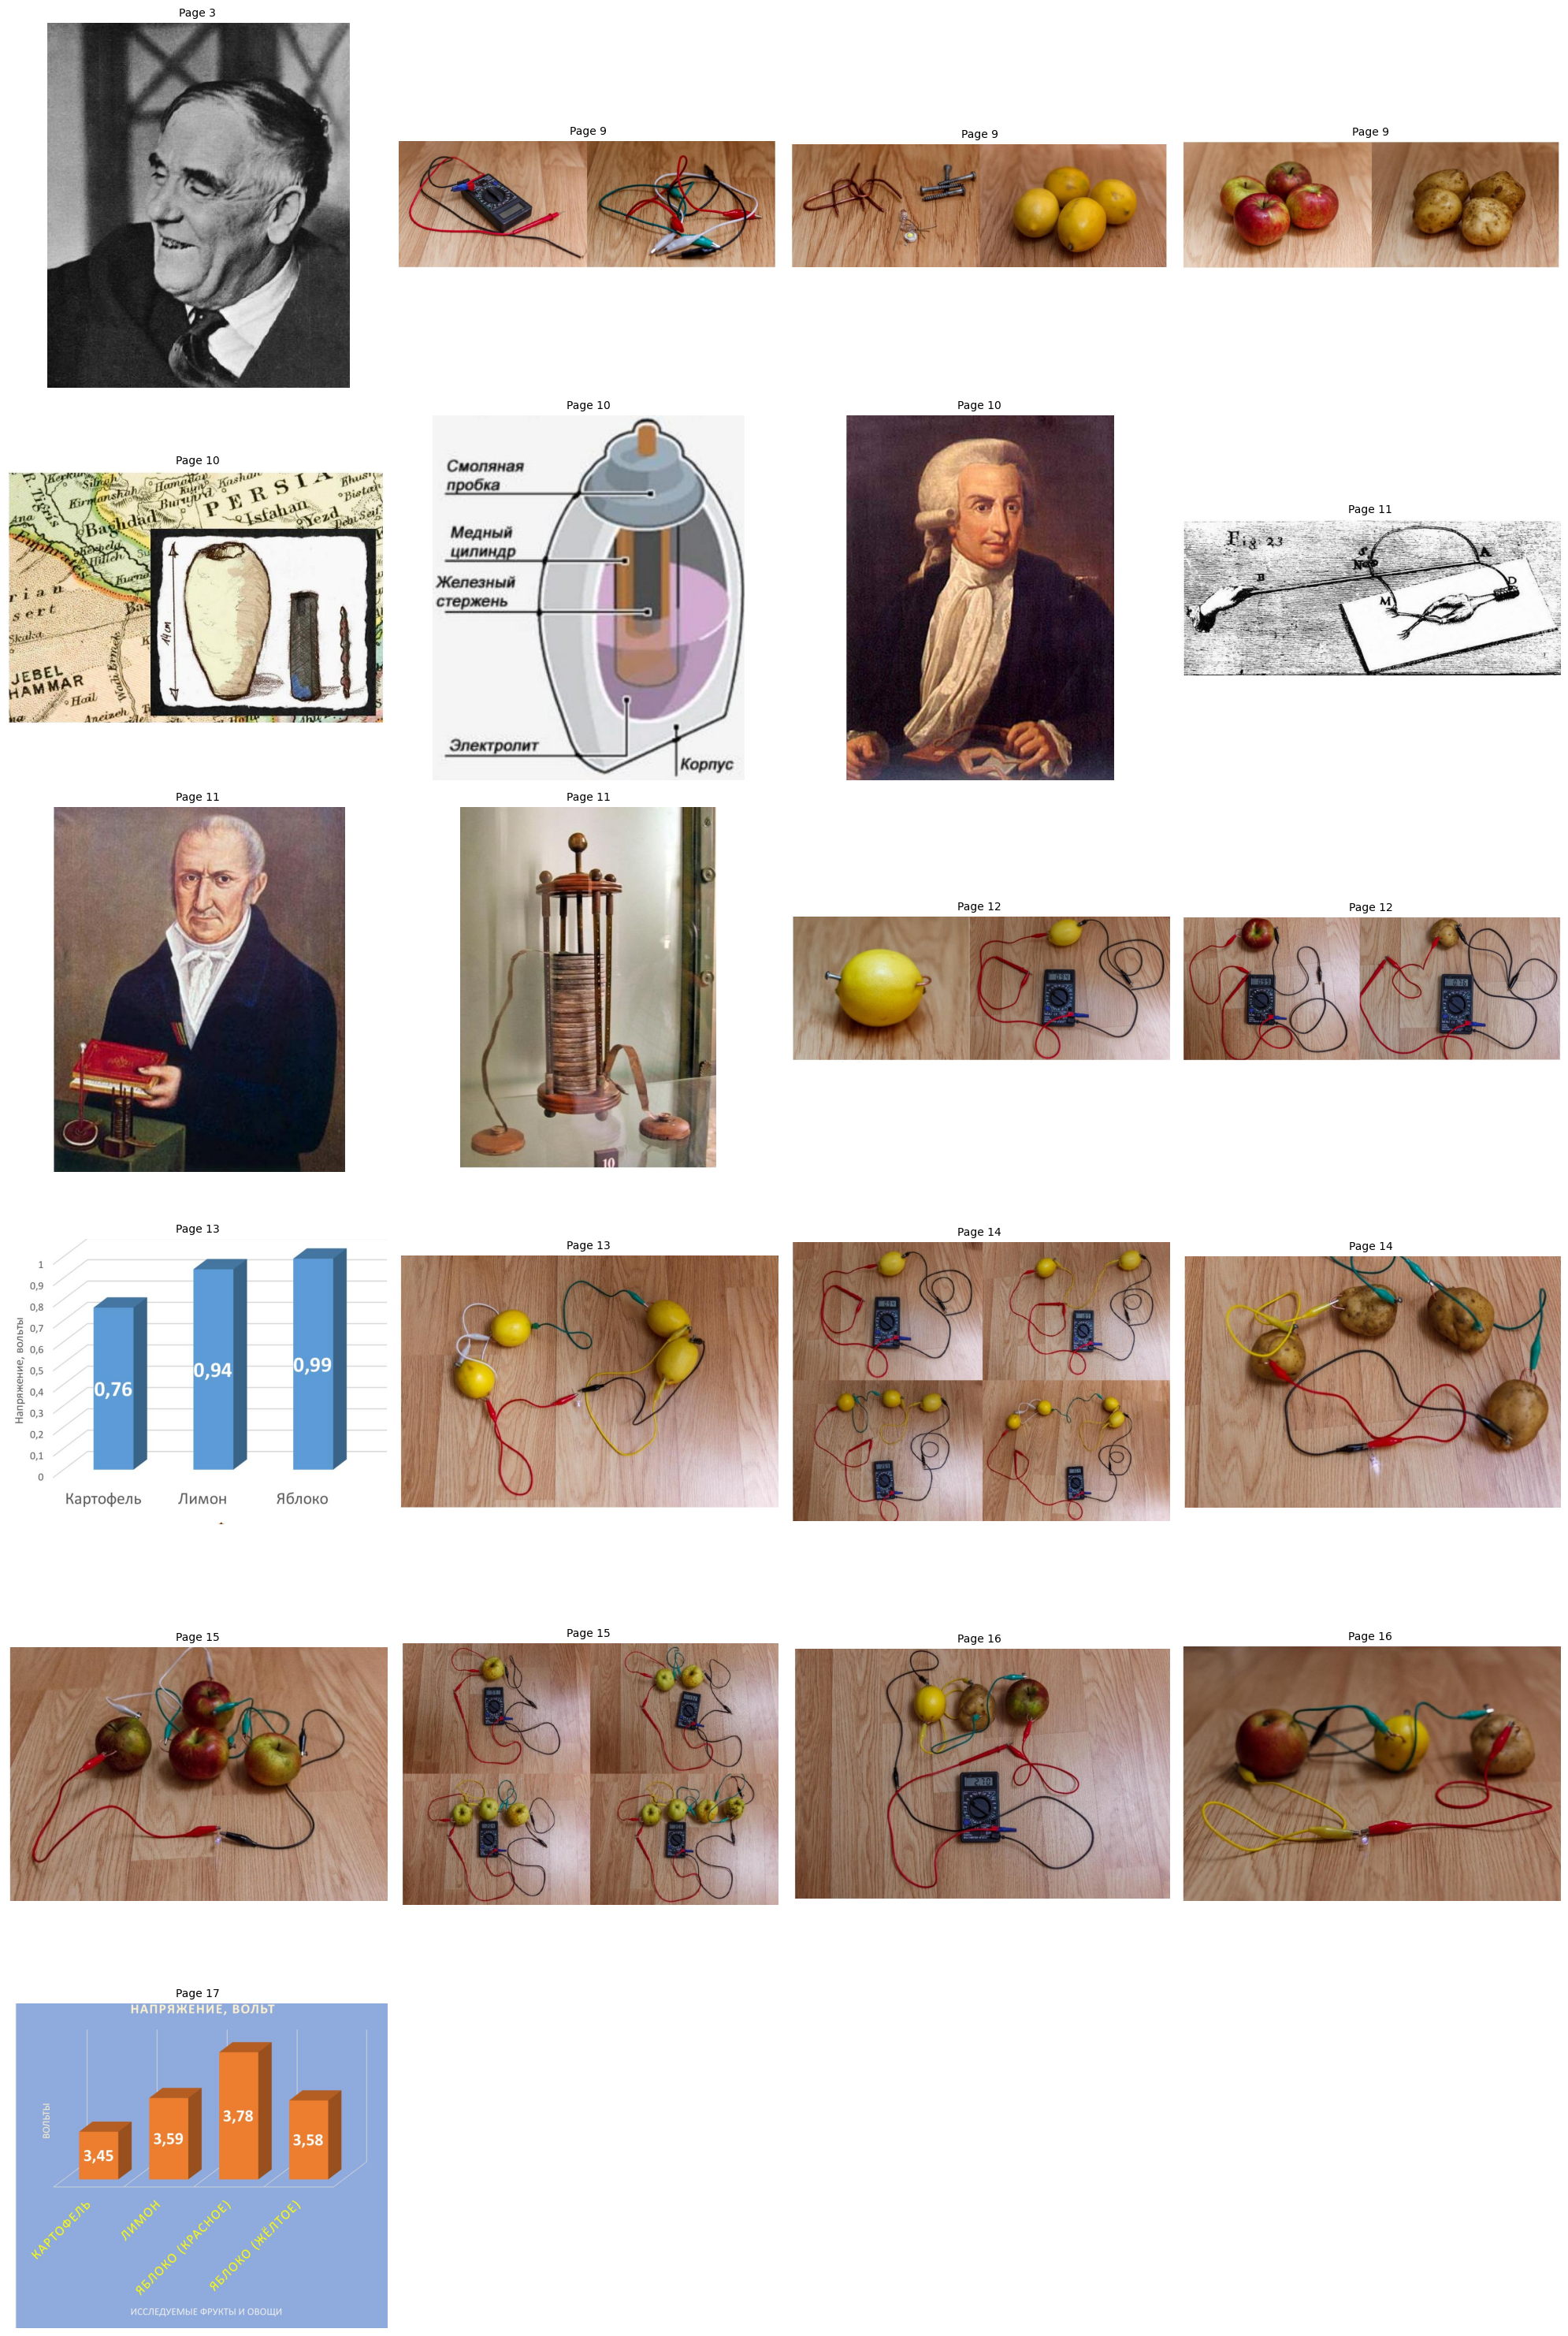

In [19]:
display_images_from_metadata(extracted_image_data)

### Извлечение таблиц

In [20]:
from unstructured.documents.elements import Table

In [21]:
def extract_table_metadata(esg_report, source_document):
    # Инициализация пустого списка для хранения метаданных таблиц
    table_data = []

    # Проход по всем элементам в esg_report
    for element in esg_report:
        # Проверка, является ли элемент таблицей (объектом Table)
        if isinstance(element, Table):
            # Извлечение номера страницы из метаданных элемента
            page_number = element.metadata.page_number

            # Преобразование таблицы в строковое представление
            table_content = str(element)

            # Добавление метаданных таблицы в список table_data
            table_data.append({
                "source_document": source_document,  # Название или путь к исходному документу
                "page_number": page_number,          # Номер страницы, на которой находится таблица
                "table_content": table_content       # Содержимое таблицы в виде строки
            })

    # Возврат списка с метаданными таблиц
    return table_data

In [22]:
extracted_table_data = extract_table_metadata(report_raw_data, report_path)

Проверим, что все таблицы извлечены корректно.

In [23]:
extracted_table_data

[{'source_document': '/content/alternativnye-istochniki-energii.pdf',
  'page_number': 2,
  'table_content': 'Введение 3 1.Основная часть 1.1. История создания «Парфянской батареи» 5 1.2. Создание первого электрического элемента 5 1.3. Виды альтернативной энергетики | 6 2.Практическая часть 2.1 Создание батарейки из овощей и фруктов З.Заключение Литература Приложение'},
 {'source_document': '/content/alternativnye-istochniki-energii.pdf',
  'page_number': 7,
  'table_content': 'Фрукт или овощ Напряжение, вольт Картофель 3,45 Лимон 3,59 Яблоко (красное) 3,78 Яблоко (жёлтое) 3,58'}]

# Мой диплом

In [24]:
report_raw_data = partition_pdf(
    filename='/content/НГФ_21.03.01_СТ-20_Быков_Е_Д.pdf',
    strategy="hi_res",
    languages=["rus"],
    extract_images_in_pdf=True,
    extract_image_block_to_payload=False,
    extract_image_block_output_dir="./data/images/"
    )

In [26]:
extracted_data = extract_text_with_metadata(report_raw_data, '/content/НГФ_21.03.01_СТ-20_Быков_Е_Д.pdf')

In [30]:
extracted_image_data = extract_image_metadata(report_raw_data, '/content/НГФ_21.03.01_СТ-20_Быков_Е_Д.pdf')

In [28]:
extracted_table_data = extract_table_metadata(report_raw_data, '/content/НГФ_21.03.01_СТ-20_Быков_Е_Д.pdf')

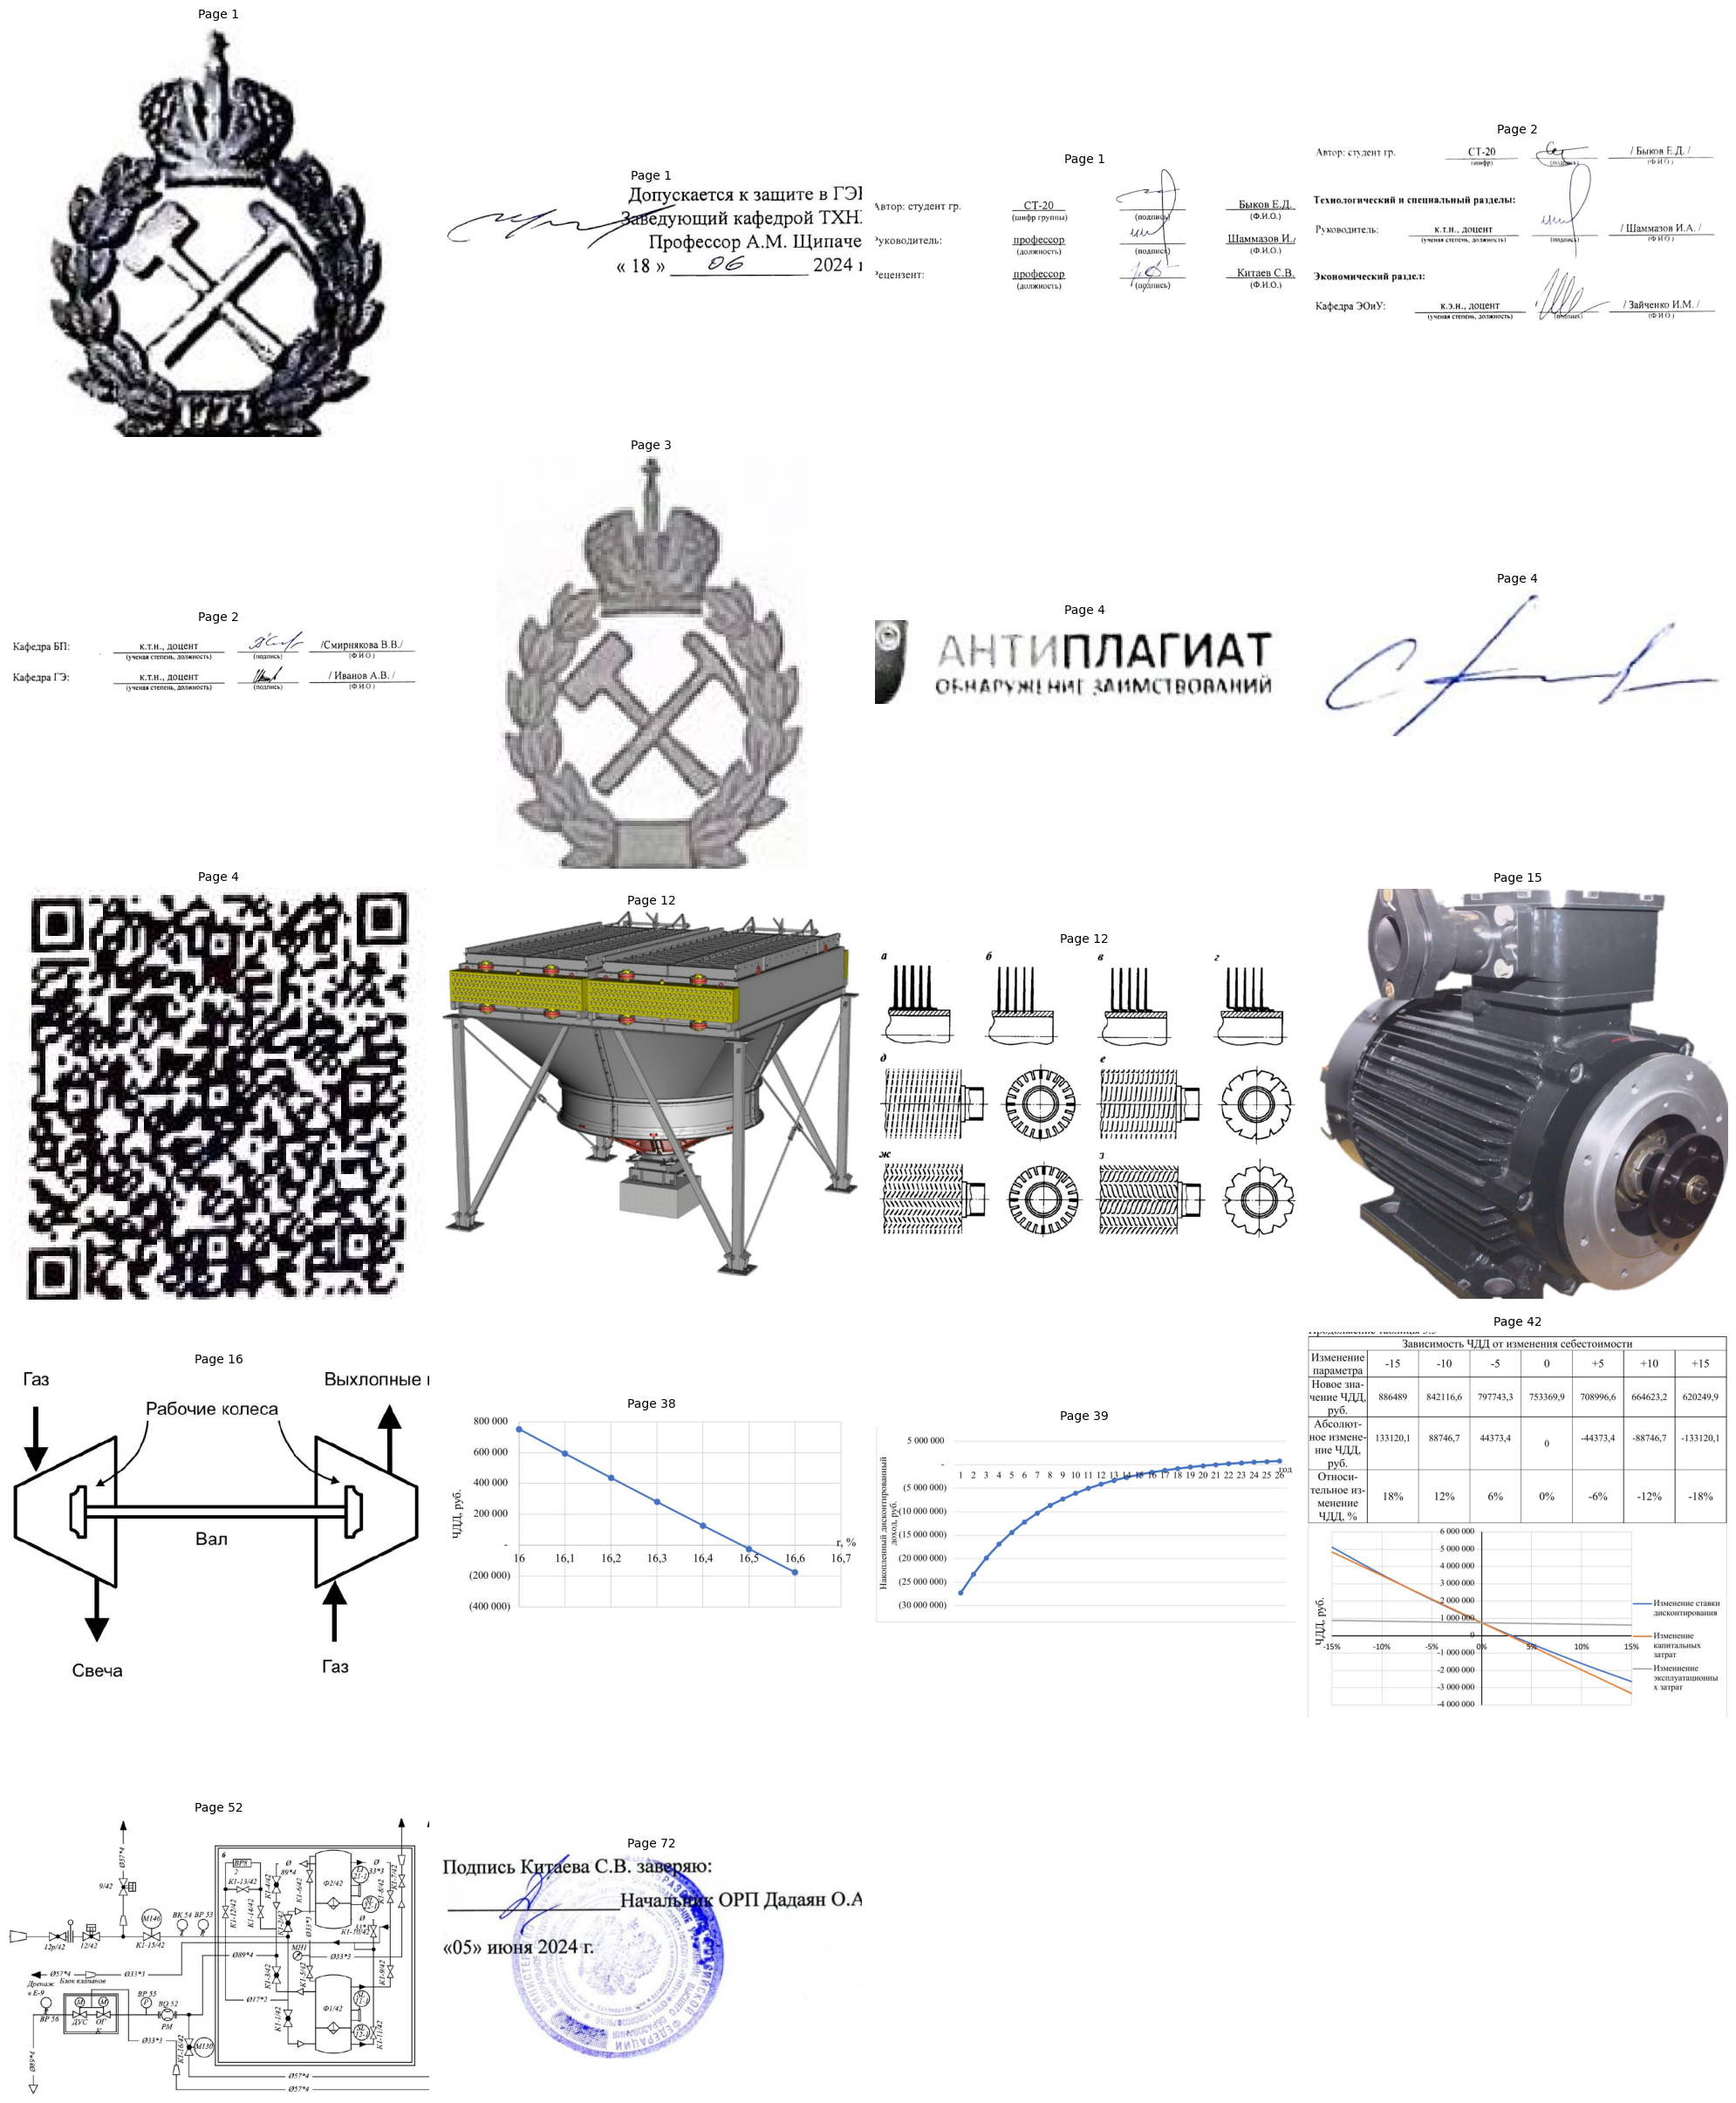

In [31]:
display_images_from_metadata(extracted_image_data)

In [33]:
len(extracted_data)

521

In [35]:
len(extracted_table_data)

24

In [41]:
print(extracted_table_data[20]['table_content'].replace(' | ', '\n'))

Категория помеще- Категория помещения НИЯ Б Горючие пыли или волокна, легковоспламеняющиеся жидкости с тем- взрывопо-
пературой вспышки более 28 °С, горючие жидкости в таком количе- жаро- стве, что могут образовывать взрывоопасные пылевоздушные или па- опасность
ровоздушные смеси, при воспламенении которых развивается расчет- ное избыточное давление взрыва в помещении, превышающее 5 кПа В1-В4 Горючие и трудногорючие жидкости, твердые горючие и трудногорю- ожаро-
чие вещества и материалы (в том числе пыли и волокна), вещества и опасность
материалы, способные при взаимодействии с водой, кислородом воз- духа или друг с другом только гореть, при условии, что помещения, в которых они находятся (обращаются), не относятся к категории А или Б Г Негорючие вещества и материалы в горячем, раскаленном или рас- умеренная
плавленном состоянии, процесс обработки которых сопровождается пожаро-
выделением лучистого тепла, искр и пламени, и (или) горючие газы, опасность
жидкости и твердые вещества, кото